# Import Libraries

In [1]:
# For metadata/feature processing
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

# For neural network
import tensorflow as tf

# For Accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# For image
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Meta Data
Not all dataset comes with prepared **metadata** (csv file containing file/image/feature/label info). Thus we need to learn how to prepare one for a custom dataset.

## Get Image Paths
First we'll use `glob` to access the file paths of each image to link them to their labels and data split.



In [2]:
train_paths = glob('/kaggle/input/mnist-dataset/mnist_png/training/*/*png')
print(f"Num Train: {len(train_paths)}")

test_paths = glob('/kaggle/input/mnist-dataset/mnist_png/testing/*/*png')
print(f"Num Test: {len(test_paths)}")

Num Train: 60000
Num Test: 10000


## Brain Storm üß†
Which image paths following code will load?
```py
 glob('/kaggle/input/mnist-dataset/mnist_png/*/0/*png')
```

## Build DataFrame (CSV File)

In [3]:
print('Train:')
train_df = pd.DataFrame(train_paths, columns=['image_path'])
display(train_df.head(2))

print('Test:')
test_df = pd.DataFrame(test_paths, columns=['image_path'])
display(test_df.head(2))

Train:


image_path
0  /kaggle/input/mnist-dataset/mnist_png/training...
1  /kaggle/input/mnist-dataset/mnist_png/training...

Test:


image_path
0  /kaggle/input/mnist-dataset/mnist_png/testing/...
1  /kaggle/input/mnist-dataset/mnist_png/testing/...

# Sample from Data
To reduce time we've down sampled the data. If you are welcome to run on the full dataset. To do so, simply comment out the cell.

In [4]:
train_df = train_df.sample(10000, random_state=42)
test_df = test_df.sample(2000, random_state=42)

# Retreive Metadata
In the following cell we'll retreive `train-test` split and `class` infomation from **image path**. 

> We'll use `.split()` function to divide the string with `/` delimeter to extract necessary information.

Example:
```python
'/kaggle/input/mnist-dataset/mnist_png/testing/3/1020.png'.split('/')
```

It will produce following output,
```python
['', 'kaggle', 'input', 'mnist-dataset', 'mnist_png', 'testing', '3', '1020.png']
```

In [5]:
# Train
train_df['label'] = train_df.image_path.map(lambda x: int(x.split('/')[-2])) # extract class
train_df['split'] = train_df.image_path.map(lambda x: x.split('/')[-3][:-3]) # extract data split
display(train_df.head(2))

# Test
test_df['label'] = test_df.image_path.map(lambda x: int(x.split('/')[-2]))  # extract class
test_df['split'] = test_df.image_path.map(lambda x: x.split('/')[-3][:-3])  # extract data split
test_df['split'] = test_df['split'].replace('train', 'test')

display(test_df.head(2))

image_path  label  split
12628  /kaggle/input/mnist-dataset/mnist_png/training...      5  train
37730  /kaggle/input/mnist-dataset/mnist_png/training...      1  train

image_path  label split
6252  /kaggle/input/mnist-dataset/mnist_png/testing/...      1  test
4684  /kaggle/input/mnist-dataset/mnist_png/testing/...      0  test

## Brain Storm üß†
What information will following code extract from image paths?
```python
train_df['x'] = train_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0])
```
Supose a image path is,
`/kaggle/input/mnist-dataset/mnist_png/training/7/52235.png`

In [6]:
train_df['id'] = train_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0]) # extract id
display(train_df.head(2))


test_df['id'] = test_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0]) # extract id
display(test_df.head(2))

image_path  label  split     id
12628  /kaggle/input/mnist-dataset/mnist_png/training...      5  train  30676
37730  /kaggle/input/mnist-dataset/mnist_png/training...      1  train  46326

image_path  label split    id
6252  /kaggle/input/mnist-dataset/mnist_png/testing/...      1  test  6276
4684  /kaggle/input/mnist-dataset/mnist_png/testing/...      0  test  6798

# Data Validation

Before diving deeper into the analysis, it's crucial to ensure that our metadata ‚Äì including path and label ‚Äì aligns accurately with the actual data. Any discrepancies may lead to inaccurate results, undermining the integrity of our findings.


## Utility

In [7]:
# opencv (cv2) is used for loading image
def load_image(path):
    img = cv2.imread(path, -1) # `-1` means load image as it is, thus no gray to rgb conversion
    return img

## One Sample

## Image Shape: (28, 28)
## Class: 5



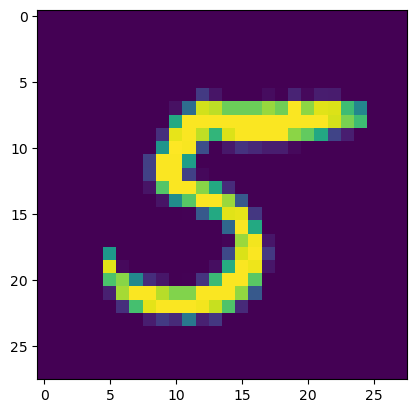

In [8]:
row = train_df.iloc[0]
img = load_image(row.image_path)
print(f"## Image Shape: {img.shape}")
print(f"## Class: {row.label}\n")
plt.imshow(img);

## Multiple Samples

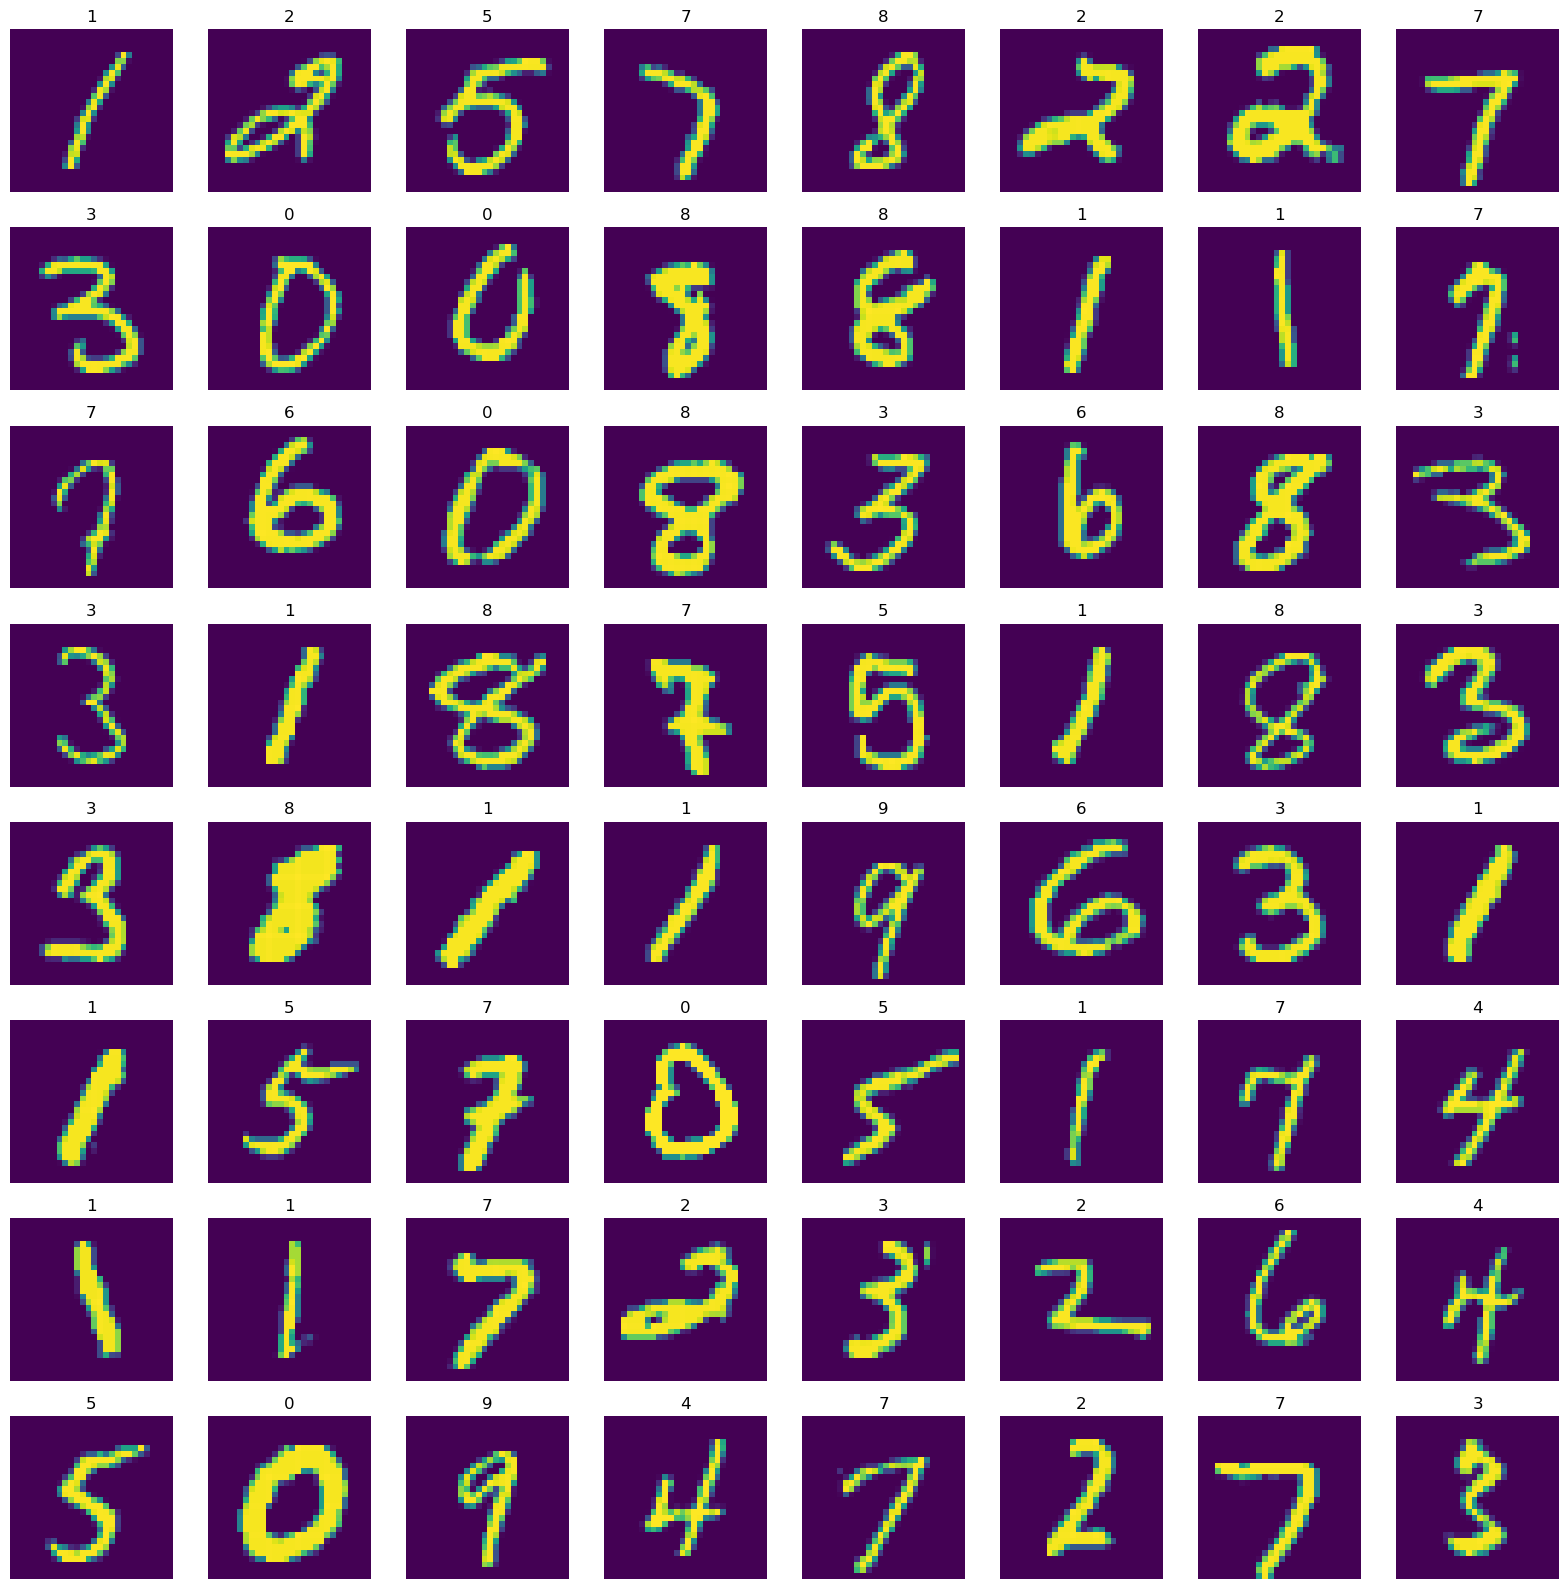

In [9]:
# Define the size of the grid
grid_size = 8

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(grid_size**2):
    # Generate random index
    img_idx = np.random.randint(0, len(train_df))
    row = train_df.iloc[img_idx]
    
    # Load the image using your preferred method (not implemented here)
    img = load_image(row.image_path)

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(str(row.label))
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# Python Class
In Python, a class is a **blueprint or template for creating objects**. It provides a way to define and organize **attributes (variables)** and **behaviors (methods)** that characterize an object of that class. The class acts as a template, and objects created from the class are instances of that class.

## Create Class

In [10]:
class Car:
    def __init__(self, make, model, year):
        self.make = make
        self.model = model
        self.year = year

    def start_engine(self):
        print("The car engine is starting.")

    def stop_engine(self):
        print("The car engine is stopping.")

    def drive(self):
        print("The car is being driven.")

In this example, we have defined a class called "Car." The class has three attributes: "make," "model," and "year." These attributes are initialized in the constructor method `__init__()`.

The class also has three methods: `start_engine()`, `stop_engine()`, and `drive()`. These methods define the behavior of a car object. When called, they print out relevant messages.

In [11]:
my_car = Car("Toyota", "Camry", 2022)
print(my_car.make)  # Output: Toyota

my_car.start_engine()  # Output: The car engine is starting.
my_car.drive()  # Output: The car is being driven.
my_car.stop_engine()  # Output: The car engine is stopping.

Toyota
The car engine is starting.
The car is being driven.
The car engine is stopping.


## Inheritance
Inheritance allows us to create new classes based on existing ones, enabling code reuse and the extension of functionality. It supports the concept of hierarchical relationships among classes, where a child class inherits attributes and methods from a parent class and can add its own unique characteristics.

In [12]:
class ElectricCar(Car):
    def __init__(self, make, model, year, battery_capacity):
        super().__init__(make, model, year)
        self.battery_capacity = battery_capacity

    def charge_battery(self):
        print("The electric car battery is charging.")

    # Override the drive() method
    def drive(self):
        print("The electric car is being driven silently.")


In [13]:
my_electric_car = ElectricCar("Tesla", "Model S", 2023, 75)
print(my_electric_car.make)  # Output: Tesla
print(my_electric_car.battery_capacity)  # Output: 75

my_electric_car.start_engine()  # Output: The car engine is starting.
my_electric_car.drive()  # Output: The electric car is being driven silently.
my_electric_car.charge_battery()  # Output: The electric car battery is charging.

Tesla
75
The car engine is starting.
The electric car is being driven silently.
The electric car battery is charging.


In this example, we create an instance of `ElectricCar` called `my_electric_car`. It inherits the `make`, `model`, and `year` attributes from the `Car` class. Additionally, it has its own `battery_capacity` attribute.

We can still access the methods inherited from the `Car` class, such as `start_engine()`. However, when we call the overridden `drive()` method, the specific behavior of the electric car is executed. We also have access to the `charge_battery()` method defined in the `ElectricCar` class.

# One Hot Encoding

One-hot encoding is a process for representing categorical data as binary vectors. This technique prevents models from incorrectly interpreting categorical variables (a, b, c) as ordinal or numeric values (1, 2, 3), thereby avoiding erroneous assumptions and poor performance.

## Example

Consider a dataset with a categorical variable **"Fruit"** comprising three categories: **"Apple," "Banana,"** and **"Orange."** Encoding these categories as 0, 1, and 2 without using one-hot encoding might lead the model to interpret them as ordinal values. This could result in flawed predictions due to the model's incorrect assumptions about the numerical proximity of the categories.

By applying one-hot encoding, each category is represented as a distinct binary vector:

- **Apple**: [1, 0, 0]
- **Banana**: [0, 1, 0]
- **Orange**: [0, 0, 1]

<img src="https://www.blog.trainindata.com/assets/images/posts/ohe/cover.gif">

In [14]:
c = np.array([0, 1, 2, 1])

tf.keras.utils.to_categorical(c)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

# Data Loader
Processing large datasets that consume a significant amount of memory can be challenging. Thus loading full data on memory is not feasible. Thus our previously used code format like this is not useful,

```python
X, y = np.load('some_training_set_with_labels.npy')

# Build model
model = LinearRegression()

# Train model on dataset, where all the data is loaded on memory at once
model.fit(x=X, y=y)
```
Moreover, traditional methods may not have enough memory to handle the data effectively. In such cases, batching, which involves dividing the dataset into smaller subsets or batches, can be employed to process the data efficiently. By generating and batching datasets using multiple cores in real-time, it becomes possible to seamlessly integrate them with deep learning models.

In [15]:
class DataLoader(tf.keras.utils.Sequence):
    """
    Custom data loader for Keras model training.
    Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Args:
        paths (list): List of file paths for the images.
        labels (list): List of corresponding labels for the images.
        batch_size (int): Number of samples per batch.
        num_classes (int): Number of classes in the dataset.
        dim (tuple): Dimensions of the input images.
        shuffle (bool): Whether to shuffle the data after each epoch.

    Methods:
        __len__(): Returns the number of batches per epoch.
        __getitem__(index): Generates one batch of data.
        on_epoch_end(): Updates indexes after each epoch.
        __data_generation(batch_indexes): Generates data for a batch.
    """

    def __init__(self, paths, labels, batch_size=32, num_classes=10,
                 dim=(28, 28), shuffle=True):
        """Initialization method for the DataLoader class."""
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_indexes)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Store sample
            X[i,] = load_image(self.paths[idx])

            # Store class
            y[i] = self.labels[idx]

        # Flatten the image pixels for Dense layer
        X = X.reshape(self.batch_size, -1)  # shape: (32, 28, 28) => (32, 28*28) => (32, 784)

        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0

        # Apply one-hot encoding to labels [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)

        return X, y

## Loader check

In [16]:
paths = train_df.image_path.tolist()
labels = train_df.label.tolist()

train_loader = DataLoader(paths, labels, batch_size=16)

imgs, tars = train_loader.__getitem__(0)
print("Images:\n", imgs)

print("\nLabels:\n", tars)

Images:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Labels:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## Visualize Loader

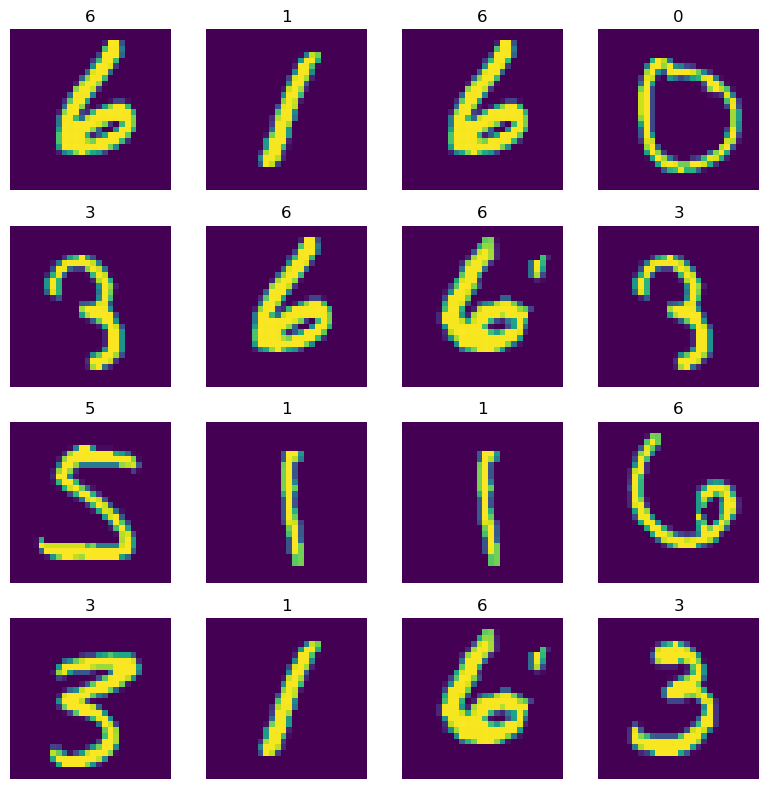

In [17]:
# Define the size of the grid
grid_size = 4

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(16):
    # Generate random index
    img_idx = np.random.randint(0, 16)
    
    # Load the image
    img = imgs[img_idx].reshape(28, 28) # images are feed as flatten to models
    
    # Get Label
    tar = tars[img_idx].argmax(axis=-1) # label is one hot encoded

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(str(tar))
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# Training
Now let's train a digit recognition model in other words, "‡¶ö‡¶≤‡ßã ‡¶Ö‡¶ô‡ßç‡¶ï ‡¶∂‡¶ø‡¶ñ‡¶æ‡¶á" üë∂. 

<img src="https://miro.medium.com/v2/resize:fit:1280/1*ATKZX26sQmuto5cc-y37gg.gif" width=700>

In [18]:
# Step 1: Get train-test image paths and labels
train_paths = train_df['image_path'].tolist()
train_labels = train_df['label'].tolist()

test_paths = test_df['image_path'].tolist()
test_labels = test_df['label'].tolist()

# Step 2: Data loader
train_loader = DataLoader(train_paths, train_labels, batch_size=128)

test_loader = DataLoader(test_paths, test_labels, batch_size=128, shuffle=False)


# Step 3: Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28*28,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Step 4: Model training
print('## Training')
model.fit(train_loader,
          validation_data=test_loader,
          epochs=5,
          verbose=1)

# Step 5: Predict on test data
print("\n## Inference")
test_loader = DataLoader(test_paths, test_labels, batch_size=100, shuffle=False)
predictions = model.predict(test_loader)

# Step 6: Measure performance
acc = accuracy_score(test_labels, predictions.argmax(-1))
print(f"\n## Accuracy: {acc}")

report = classification_report(test_labels, predictions.argmax(-1))
print("\n## Classification Report:\n", report)

## Training
Epoch 1/5
79/79 [==============================] - 43s 495ms/step - loss: 0.4986 - accuracy: 0.8534 - val_loss: 0.2795 - val_accuracy: 0.9092
Epoch 2/5
79/79 [==============================] - 13s 161ms/step - loss: 0.2168 - accuracy: 0.9348 - val_loss: 0.1505 - val_accuracy: 0.9512
Epoch 3/5
79/79 [==============================] - 12s 154ms/step - loss: 0.1215 - accuracy: 0.9655 - val_loss: 0.4003 - val_accuracy: 0.9229
Epoch 4/5
79/79 [==============================] - 12s 157ms/step - loss: 0.0992 - accuracy: 0.9688 - val_loss: 0.1735 - val_accuracy: 0.9375
Epoch 5/5
79/79 [==============================] - 12s 155ms/step - loss: 0.0554 - accuracy: 0.9836 - val_loss: 0.1318 - val_accuracy: 0.9526

## Inference
20/20 [==============================] - 2s 104ms/step

## Accuracy: 0.9525

## Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.97      1.00      0.98       2

# Result Analysis

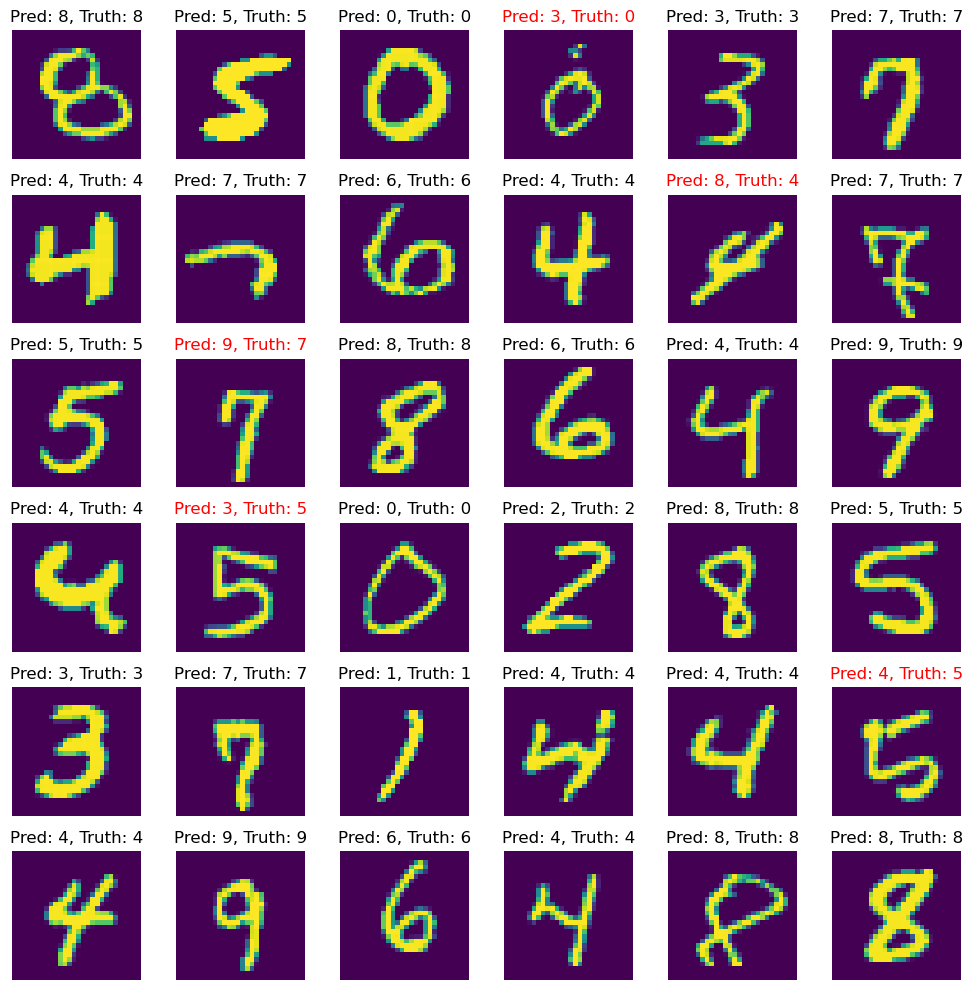

In [19]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 36
sqrt_num_images = int(np.sqrt(num_images))
indices = np.random.choice(len(test_paths), num_images, replace=False)
fig, axes = plt.subplots(nrows=sqrt_num_images, ncols=sqrt_num_images, figsize=(10, 10))

for i, idx in enumerate(indices):
    row = i // sqrt_num_images
    col = i % sqrt_num_images

    image_path = test_paths[idx]
    image = load_image(image_path)  # Load and preprocess single image
    prediction = np.argmax(predictions[idx], axis=-1)
    ground_truth = test_labels[idx]

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

    if prediction == ground_truth:
        axes[row, col].set_title(f'Pred: {prediction}, Truth: {ground_truth}')
    else:
        axes[row, col].set_title(f'Pred: {prediction}, Truth: {ground_truth}', color='red')

plt.tight_layout()
plt.show()
